In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers

from IPython import display

In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()   # train_images: 6000x28x28, train_labels: 6000
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')   # train_images: 6000x28x28x1의 float32 형태
train_images = (train_images - 127.5) / 127.5    # 이미지를 [-1, 1]로 정규화한다. 향후 생성자도 [-1, 1] 범위로 이미지 생성한다.

BUFFER_SIZE = 60000       # train_images의 총 개수
BATCH_SIZE = 256          # 학습 시 처리단위. 보통 32, 64, 256, ... batch를 이용하는 것이 성능에 좋으며 작을수록 수렴 시 메모리가 부족할 때 좋으나, fluctuate 경향 있으니 적절한 값 설정. 보통 64나 128 추천한다. 

# 데이터 배치를 만들고 섞어서 tensor로 불러온다.
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [3]:
def make_generator_model():
    model = tf.keras.Sequential()
   
    model.add(layers.Dense(256, use_bias=False, input_shape=(100,)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))    # 출력값을 균등화
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(np.prod(28*28), activation='tanh'))
    model.add(layers.Reshape((28,28,1)))
              
    model.summary()
    return model

In [4]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Flatten(input_shape=(28, 28, 1)))
    model.add(layers.Dense(512))                         # 784(28x28) => 512
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dense(256))                         # 256
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.summary()
    return model

In [5]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# fake image를 넣었을 때 1이 나오도록 학습
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)  

# real image를 넣었을 때 1이 나오게, fake image를 넣었을 때 0이 나오게 학습
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [6]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    
        # generator에 noise 넣고 fake image 생성
        generated_images = generator(noise, training=True)
    
        # discriminator에 real image와 fake image 넣고 판별값 리턴
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # fake image를 discriminator가 1로 학습 하도록 업데이트
        gen_loss = generator_loss(fake_output)
        # real image loss와 fake image loss 합한 total loss 리턴
        disc_loss = discriminator_loss(real_output, fake_output)

    # tape에 기록하며 자동미분 실행
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [7]:
# 중간중간 이미지 저장을 위한 함수
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)   # training == False : 모든 층들이 추론 모드로 실행됨.

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
        plt.axis('off')

In [8]:
def train(dataset, epochs):
    for epoch in range(epochs):

        # 이미지 넣고 학습 실행. 
        for image_batch in dataset:
            train_step(image_batch)

        # 이미지를 50 epoch마다 출력
        if epoch % 50 == 0:
            generate_and_save_images(generator,epoch + 1,seed)

    # 마지막 에포크가 끝난 후 생성합니다.
    display.clear_output(wait=True)
    generate_and_save_images(generator,epochs,seed)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


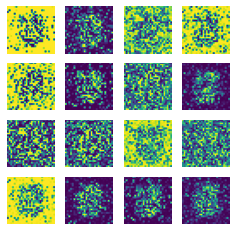

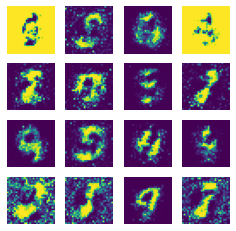

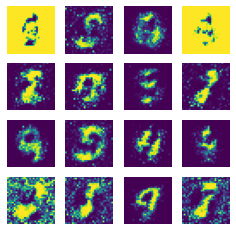

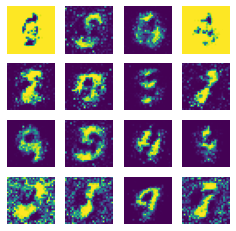

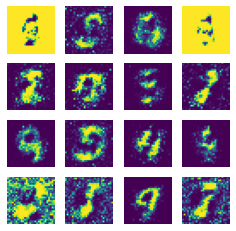

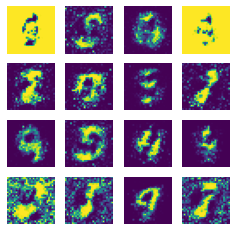

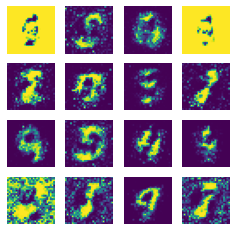

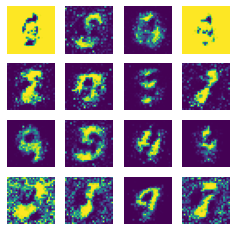

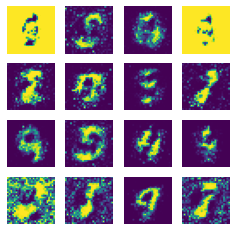

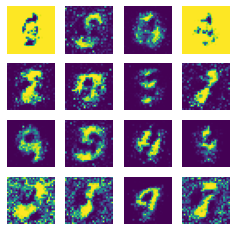

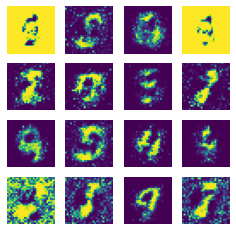

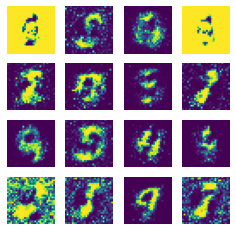

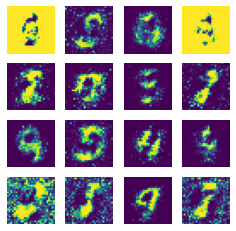

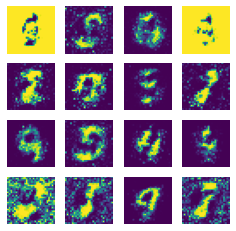

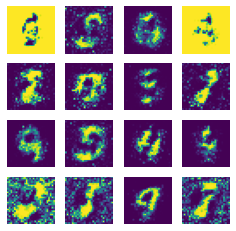

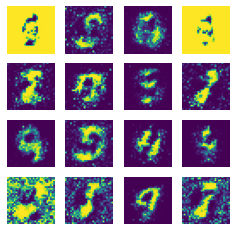

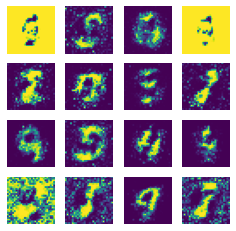

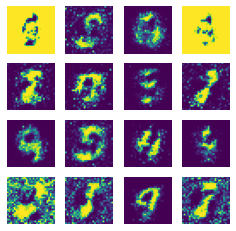

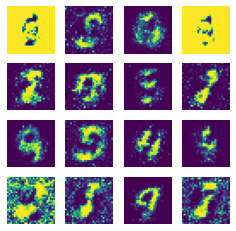

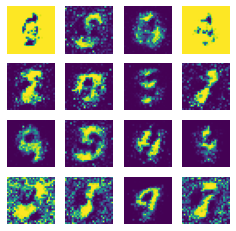

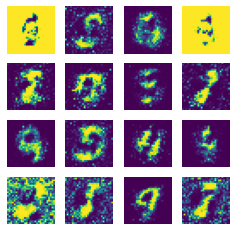

In [9]:
# hyper parameter 설정 
EPOCHS = 1000
noise_dim = 100
num_examples_to_generate = 16

generator = make_generator_model()
discriminator = make_discriminator_model()

# 출력 용도로 random noise 생성
seed = tf.random.normal([num_examples_to_generate, noise_dim])

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

train(train_dataset, EPOCHS)